In [3]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Model
%matplotlib inline

Using TensorFlow backend.


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

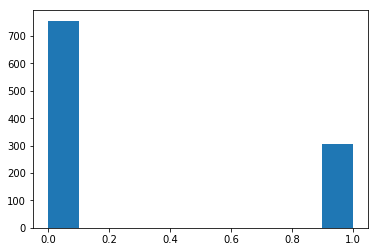

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])

df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition']) # biclass

## 1. Using fingerprint

In [5]:
fps = rdkitDescriptors.batch_compute_rdkit_fingerprints(df['SMILES'])
len(fps[0])

2048

* Train test split 75-25

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(fps, true_label_biclass, test_size=0.25, random_state=42)

## 1.1 raw fingerprint for supervised classfication

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
clf = RandomForestClassifier(n_estimators=500, max_depth=5,random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [10]:
y_pred=clf.predict(X_test)

* Since this is about classifying to the correct class, we need to use accuracy score as metrics 

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
from sklearn.metrics import log_loss

In [13]:
from sklearn.metrics import hamming_loss, hinge_loss

In [14]:
accuracy_score(y_test, y_pred) # not bad

0.8157894736842105

In [15]:
def classifier_losses(y_true, y_pred,normalize = True):
    loss_dict = {}
    loss_dict['hamming_loss'] = hamming_loss(y_true, y_pred)
    loss_dict['hinge_loss'] = hinge_loss(y_true, y_pred)
    return loss_dict

In [16]:
classifier_losses(y_test, y_pred)

{'hamming_loss': 0.18421052631578946, 'hinge_loss': 0.8947368421052632}

In [17]:
log_loss(y_test, clf.predict_proba(X_test), normalize=True, labels=y_test)

0.43900246248660757

* Fewer estimators just as reference to latent space classification

In [18]:
clf2 = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42)
clf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [19]:
y_pred2=clf2.predict(X_test)

In [20]:
accuracy_score(y_test,y_pred2) 

0.8195488721804511

In [21]:
classifier_losses(y_test, y_pred2)

{'hamming_loss': 0.18045112781954886, 'hinge_loss': 0.8909774436090225}

In [22]:
log_loss(y_test, clf2.predict_proba(X_test), normalize=True, labels=y_test)

0.4404682883230851

## 1.2 autoencoded fingerprint (extract the hidden layer) for supervised classfication

In [23]:
from dimreducer import DeepAutoEncoder as DAE

In [24]:
dims =[2048,1028,128]
autoencoder = DAE(dims, act='relu')
autoencoder.build_model(norm=False)
history = autoencoder.train_model(fps, norm_feature=False, epochs=100)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1063/1063 [==============================] - ETA: 2s - loss: 0.086 - ETA: 0s - loss: 0.085 - ETA: 0s - loss: 0.084 - ETA: 0s - loss: 0.082 - 1s 1ms/step - loss: 0.0819
Epoch 2/100
1063/1063 [==============================] - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.072 - ETA: 0s - loss: 0.071 - 1s 734us/step - loss: 0.0717
Epoch 3/100
1063/1063 [==============================] - ETA: 0s - loss: 0.064 - ETA: 0s - loss: 0.066 - ETA: 0s - loss: 0.064 - ETA: 0s - loss: 0.064 - 1s 676us/step - loss: 0.0646
Epoch 4/100
1063/1063 [==============================] - ETA: 0s - loss: 0.062 - ETA: 0s - loss: 0.060 - ETA: 0s - loss: 0.059 - ETA: 0s - loss: 0.058 - 1s 771us/step - loss: 0.0579
Epoch 5/100
1063/1063 [==============================] - ETA: 0s - loss: 0.055 - ETA: 0s - loss: 0.055 - ETA: 0s - loss: 0.053 - ETA: 0s - loss: 0.052 - 1

1063/1063 [==============================] - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.010 - 1s 819us/step - loss: 0.0106
Epoch 43/100
1063/1063 [==============================] - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - 1s 795us/step - loss: 0.0104
Epoch 44/100
1063/1063 [==============================] - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - 1s 790us/step - loss: 0.0102
Epoch 45/100
1063/1063 [==============================] - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.010 - 1s 791us/step - loss: 0.0100
Epoch 46/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - 1s 784us/step - loss: 0.0098
Epoch 47/100
1063/1063 [==============================] - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 

Epoch 87/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 720us/step - loss: 0.0088
Epoch 88/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 723us/step - loss: 0.0088
Epoch 89/100
1063/1063 [==============================] - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.008 - 1s 732us/step - loss: 0.0089
Epoch 90/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 740us/step - loss: 0.0089
Epoch 91/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 957us/step - loss: 0.0088
Epoch 92/100
1063/1063 [==============================] - ETA: 0s - loss: 0.008 - ETA

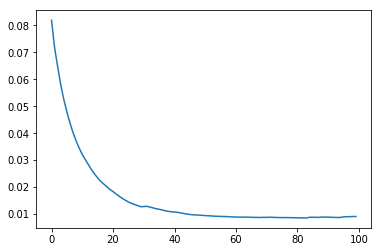

In [25]:
plt.plot(history.history['loss'])

In [26]:
encoder = Model(inputs=autoencoder.model.input, 
                outputs=autoencoder.model.get_layer(name='embedding_layer').output)
hidden_feat = encoder.predict(fps)
X_train_hid, X_test_hid, y_train_ae, y_test_ae = train_test_split(hidden_feat, true_label_biclass, test_size=0.25, random_state=42)
clf_ae = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42) # n_esimators is reduced because dimension is reduced
clf_ae.fit(X_train_hid, y_train_ae)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [27]:
y_pred_ae=clf_ae.predict(X_test_hid)

In [28]:
accuracy_score(y_test_ae, y_pred_ae) # score is slightly better

0.8421052631578947

In [29]:
classifier_losses(y_test_ae, y_pred_ae) # loss is smaller

{'hamming_loss': 0.15789473684210525, 'hinge_loss': 0.868421052631579}

In [30]:
log_loss(y_test_ae, clf_ae.predict_proba(X_test_hid), normalize=True, labels=y_test_ae) # loss is smaller

0.40170238524044655

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
confusion_matrix(y_test_ae, y_pred_ae, labels=None, sample_weight=None)

array([[182,   7],
       [ 35,  42]], dtype=int64)

In [33]:
from sklearn.utils.multiclass import unique_labels

In [34]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [35]:
class_names = np.array(["nondegradable", "degradable"])

Normalized confusion matrix
[[0.96 0.04]
 [0.53 0.47]]
Normalized confusion matrix
[[0.96 0.04]
 [0.45 0.55]]


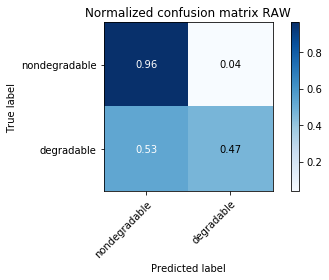

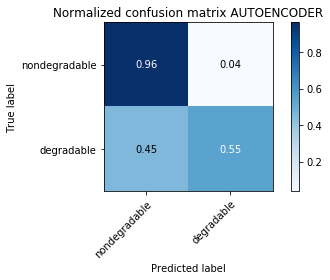

In [36]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred2, classes=class_names, normalize=True,
                      title='Normalized confusion matrix RAW')


plot_confusion_matrix(y_test, y_pred_ae, classes=class_names, normalize=True,
                      title='Normalized confusion matrix AUTOENCODER')

plt.show()

## DCE hidden layer classifier

In [41]:
autoencoder_dims = [2048,1028,128]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50, clustering_tol=1e-3)

cl_weights = np.arange(0.1, 1, 0.1)
results = []
hidden_feats=[]

for cl_weight in cl_weights:
    dce.build_model(norm=False)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    result_i = dce.train_model(fps,clustering_loss='kld', 
                               decoder_loss='binary_crossentropy',
                               training_prints=False,
                               norm_feature=False,
                               clustering_loss_weight=cl_weight)
    results.append(result_i)
    dce_encoder = Model(inputs=dce.model.input, 
                    outputs=dce.model.get_layer(name='embedding_layer').output)
    
    hidden_feats.append(dce_encoder.predict(fps))
    print('Training finished and the results are recorded')

Start to train model with cluster weight: 0.1
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with clus

Text(0.5, 1.0, 'fowlkes_mallows_score')

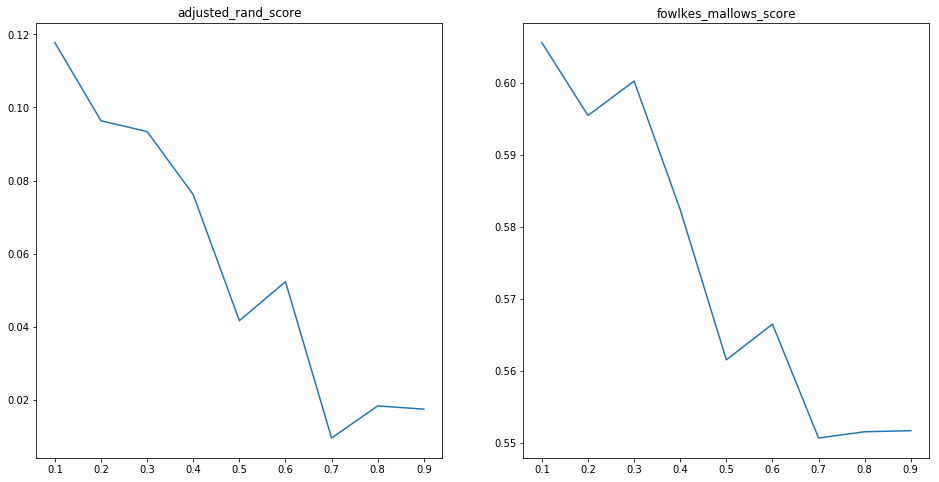

In [42]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(true_label_biclass,results[i][0],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(1,2,figsize=(16,8))

ax[0].plot(cl_weights,adjusted_rand_score)
ax[0].set_title('adjusted_rand_score')

ax[1].plot(cl_weights,fowlkes_mallows_score)
ax[1].set_title('fowlkes_mallows_score')

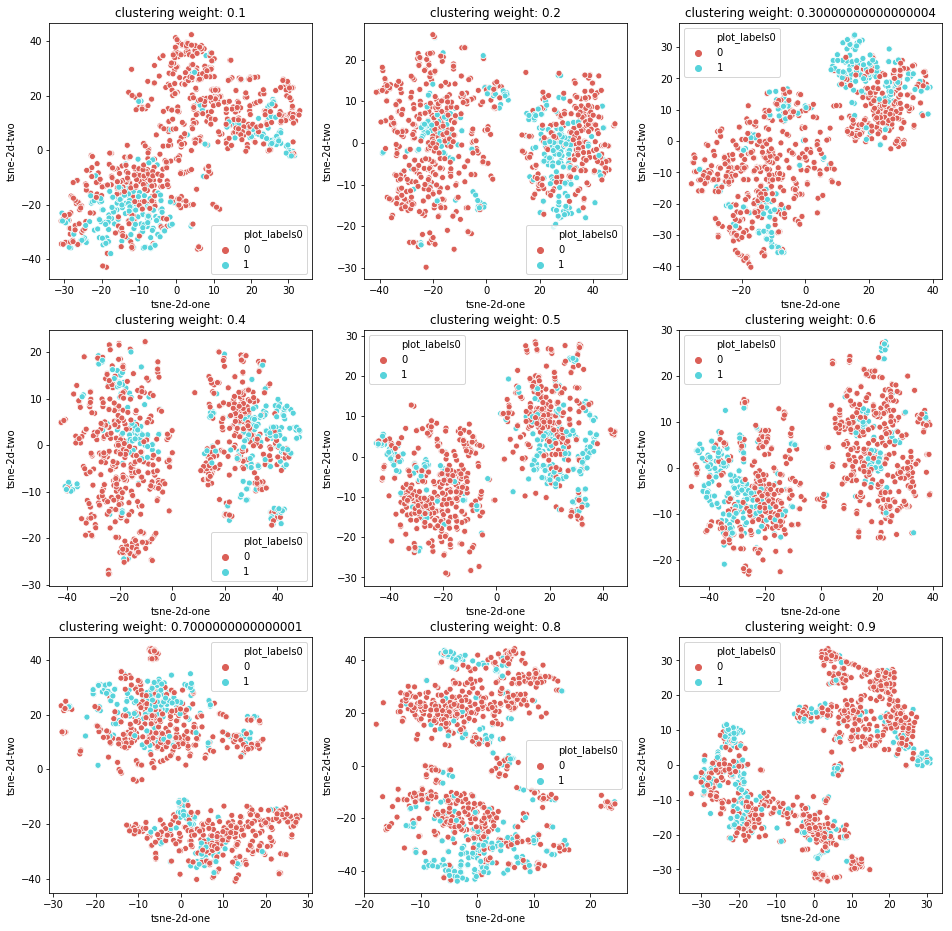

In [43]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization(input_feat=hidden_feats[i], 
                                   plot_labels=true_label_biclass,
                                   verbose=0,
                                   ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

* Take weights and use pipeline

* train test split of hidden layer and then build classifier

In [63]:
actual_ylabels = []
pred_ylabels = []
acc_scores = []
losses = []
log_losses = []
for h_feat in hidden_feats:
    X_train_dce_i, X_test_dce_i, y_train_dce_i, y_test_dce_i = train_test_split(h_feat,true_label_biclass, 
                                                                                test_size=0.25, random_state=42)
    actual_ylabels.append(y_test_dce_i)
    clf_dce_i = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42) 
    clf_dce_i.fit(X_train_dce_i, y_train_dce_i)
    y_pred_dce_i = clf_dce_i.predict(X_test_dce_i)
    pred_ylabels.append(y_pred_dce_i)
    acc_scores.append(accuracy_score(y_test_dce_i, y_pred_dce_i, normalize= True))
    losses.append(classifier_losses(y_test_dce_i, y_pred_dce_i))
    log_losses.append(log_loss(y_test_dce_i,clf_dce_i.predict_proba(X_test_dce_i), normalize=True, labels=y_test_dce_i))

In [64]:
acc_scores # worse

[0.8270676691729323,
 0.8345864661654135,
 0.8120300751879699,
 0.8233082706766918,
 0.8270676691729323,
 0.8120300751879699,
 0.8045112781954887,
 0.8082706766917294,
 0.7894736842105263]

In [65]:
losses # worse

[{'hamming_loss': 0.17293233082706766, 'hinge_loss': 0.8834586466165414},
 {'hamming_loss': 0.16541353383458646, 'hinge_loss': 0.8759398496240601},
 {'hamming_loss': 0.18796992481203006, 'hinge_loss': 0.8984962406015038},
 {'hamming_loss': 0.17669172932330826, 'hinge_loss': 0.8872180451127819},
 {'hamming_loss': 0.17293233082706766, 'hinge_loss': 0.8834586466165414},
 {'hamming_loss': 0.18796992481203006, 'hinge_loss': 0.8984962406015038},
 {'hamming_loss': 0.19548872180451127, 'hinge_loss': 0.9060150375939849},
 {'hamming_loss': 0.19172932330827067, 'hinge_loss': 0.9022556390977443},
 {'hamming_loss': 0.21052631578947367, 'hinge_loss': 0.9210526315789473}]

In [66]:
log_losses # worse

[0.4099633053712244,
 0.4215748631014601,
 0.4341268116217052,
 0.44191804416362845,
 0.44784417073441507,
 0.43978759842476006,
 0.4512501079878296,
 0.447754199571304,
 0.4555840941483821]

 * Confusion matrix

Normalized confusion matrix
[[0.95 0.05]
 [0.47 0.53]]
Normalized confusion matrix
[[0.95 0.05]
 [0.45 0.55]]
Normalized confusion matrix
[[0.96 0.04]
 [0.56 0.44]]
Normalized confusion matrix
[[0.98 0.02]
 [0.56 0.44]]
Normalized confusion matrix
[[0.97 0.03]
 [0.53 0.47]]
Normalized confusion matrix
[[0.96 0.04]
 [0.55 0.45]]
Normalized confusion matrix
[[0.97 0.03]
 [0.6  0.4 ]]
Normalized confusion matrix
[[0.96 0.04]
 [0.56 0.44]]
Normalized confusion matrix
[[0.96 0.04]
 [0.64 0.36]]


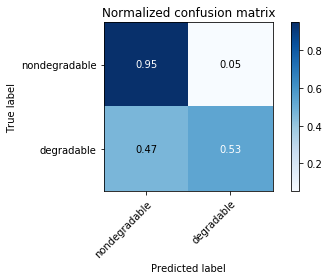

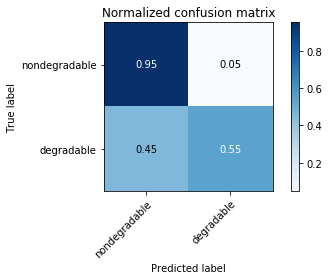

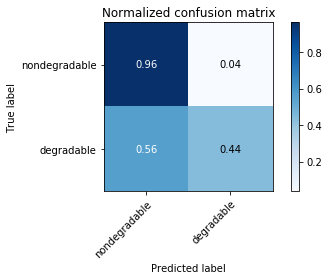

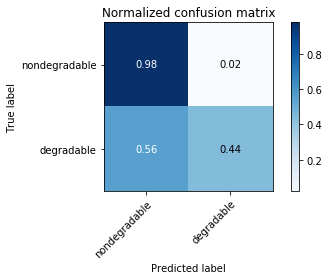

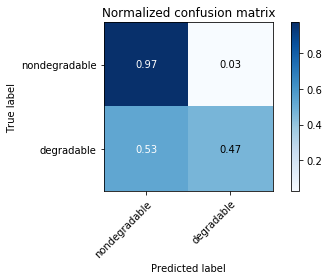

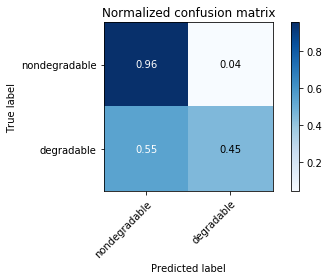

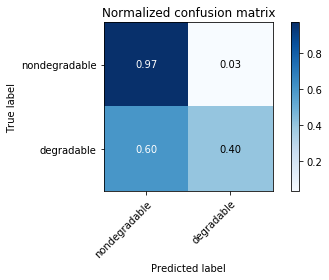

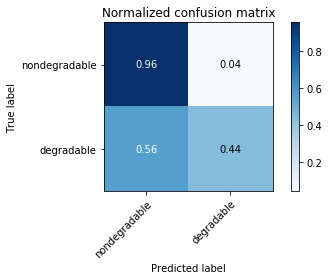

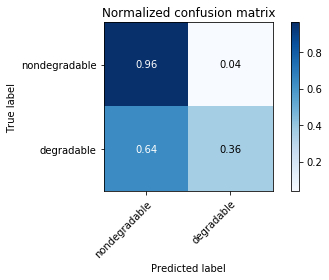

In [74]:
for i in range(9):    
    plot_confusion_matrix(actual_ylabels[i], pred_ylabels[i],
                                   classes=class_names,normalize=True,
                                   )